<div>
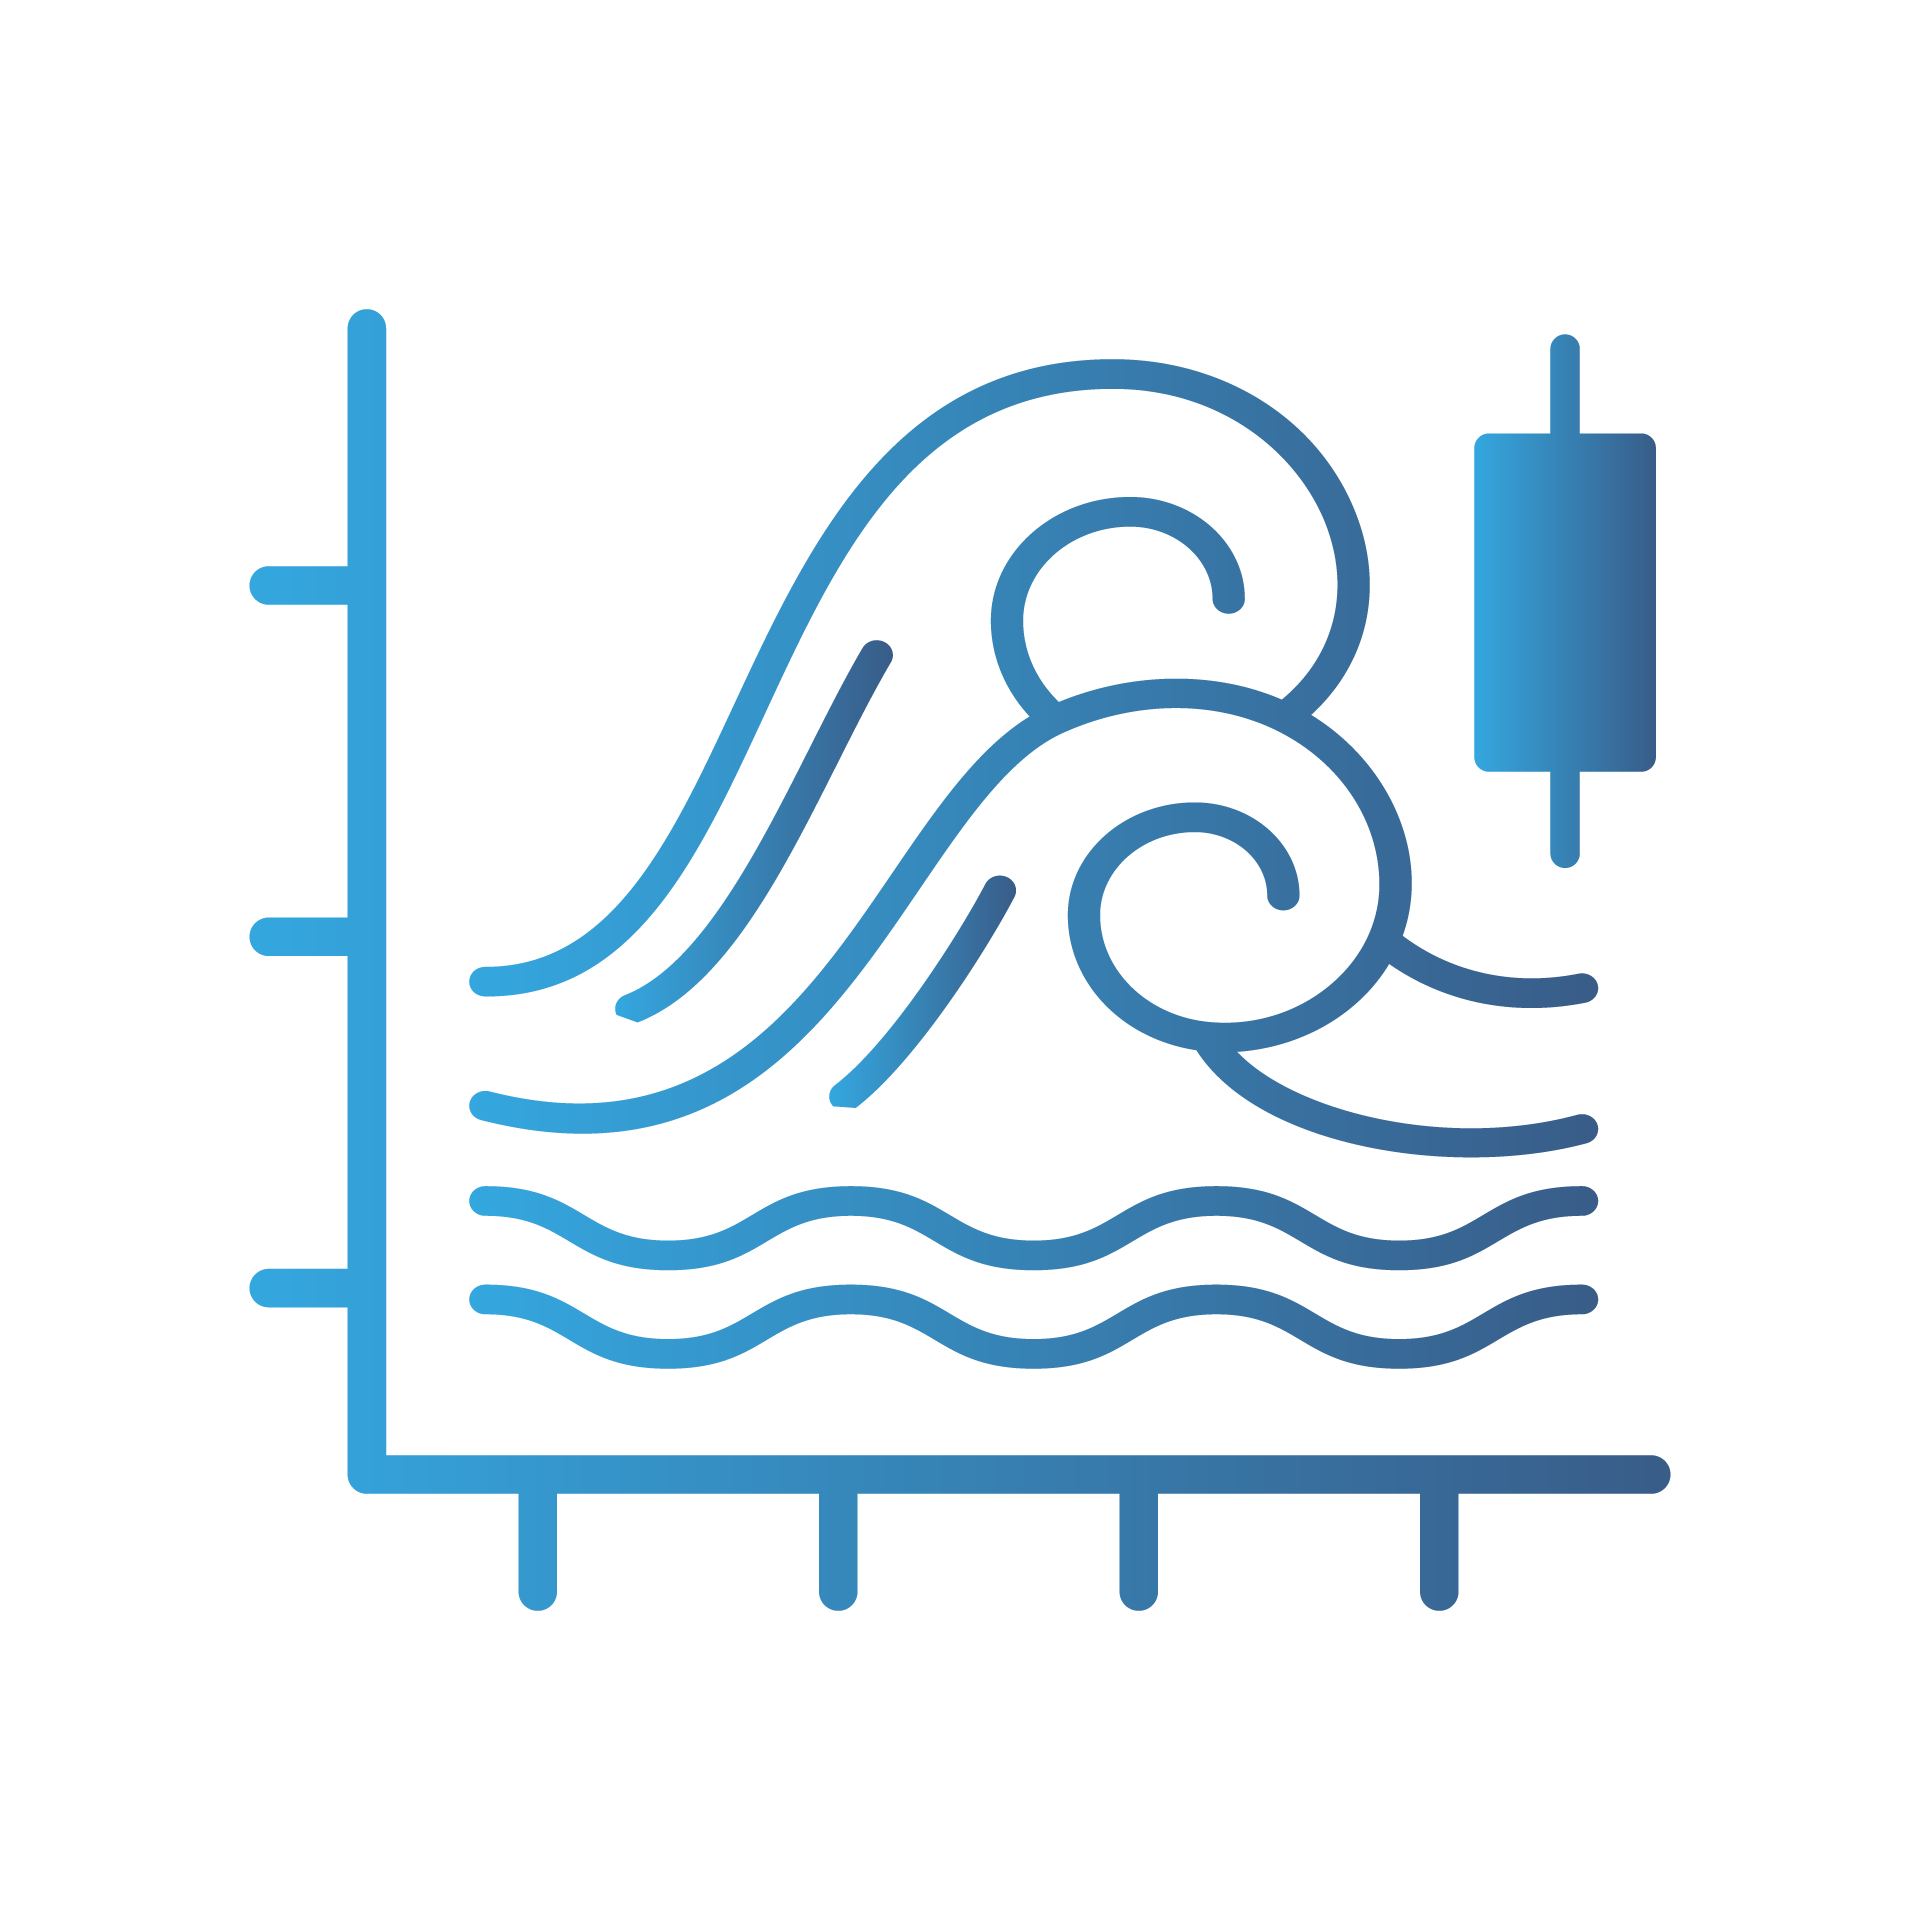
</div>

# __Ocean Regimes Indicator__: Predict and plot notebook

*Authors*: Andrea Garcia Juan (andrea.garcia.juan@ifremer.fr), Kevin Balem (kevin.balem@ifremer.fr), Guillaume Maze (gmaze@ifremer.fr), and Loïc Bachelot (loic.bachelot@ifremer.fr)
***

## Description

**The objective of this notebook is to load a model, classify a dataset (make predictions), and visualise the results with a collection of plots.**

__The Ocean Regimes Indicator__ allows to automatically, without supervision, assemble time series of ocean variables into clusters according to their seasonal variability similarities. Depending on the dataset, such clusters can show spatial coherence. Clusters will be presented through different plots. This example is based on the work of Fabrizio D'Ortenzio ([*D'Ortenzio and d'Alcalà, Biogeosciences, 2009*](https://bg.copernicus.org/articles/6/139/2009/)) and Nicolas Mayot ([*Mayot et al, Biogeosciences, 2016*](https://bg.copernicus.org/articles/13/1901/2016/)). For more information about the method, see [*Maze et al, Prg.Oc, 2017*](https://www.sciencedirect.com/science/article/pii/S0079661116300714).

As an example, a selection of the ``OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082`` CMEMS product covering the Mediterranean is used as an input dataset to be classified.

In this notebook, we're going to load an existing classification model. Note that you can develop, train and optimize a model of your own using the notebook ``ModelDevelopment_OceanRegimes.ipynb``.


***
This notebook has been developed at Laboratory for Ocean Physics and Satellite remote sensing, IFREMER, within the framework of the Blue-Cloud project. Blue-Cloud has received funding from the European Union's Horizon programme call BG-07-2019-2020, topic: [A] 2019 - Blue Cloud services, Grant Agreement n.862409

<div>
<center>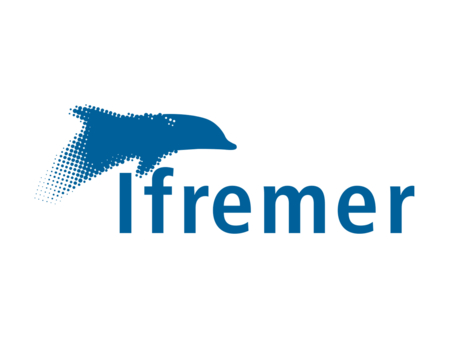 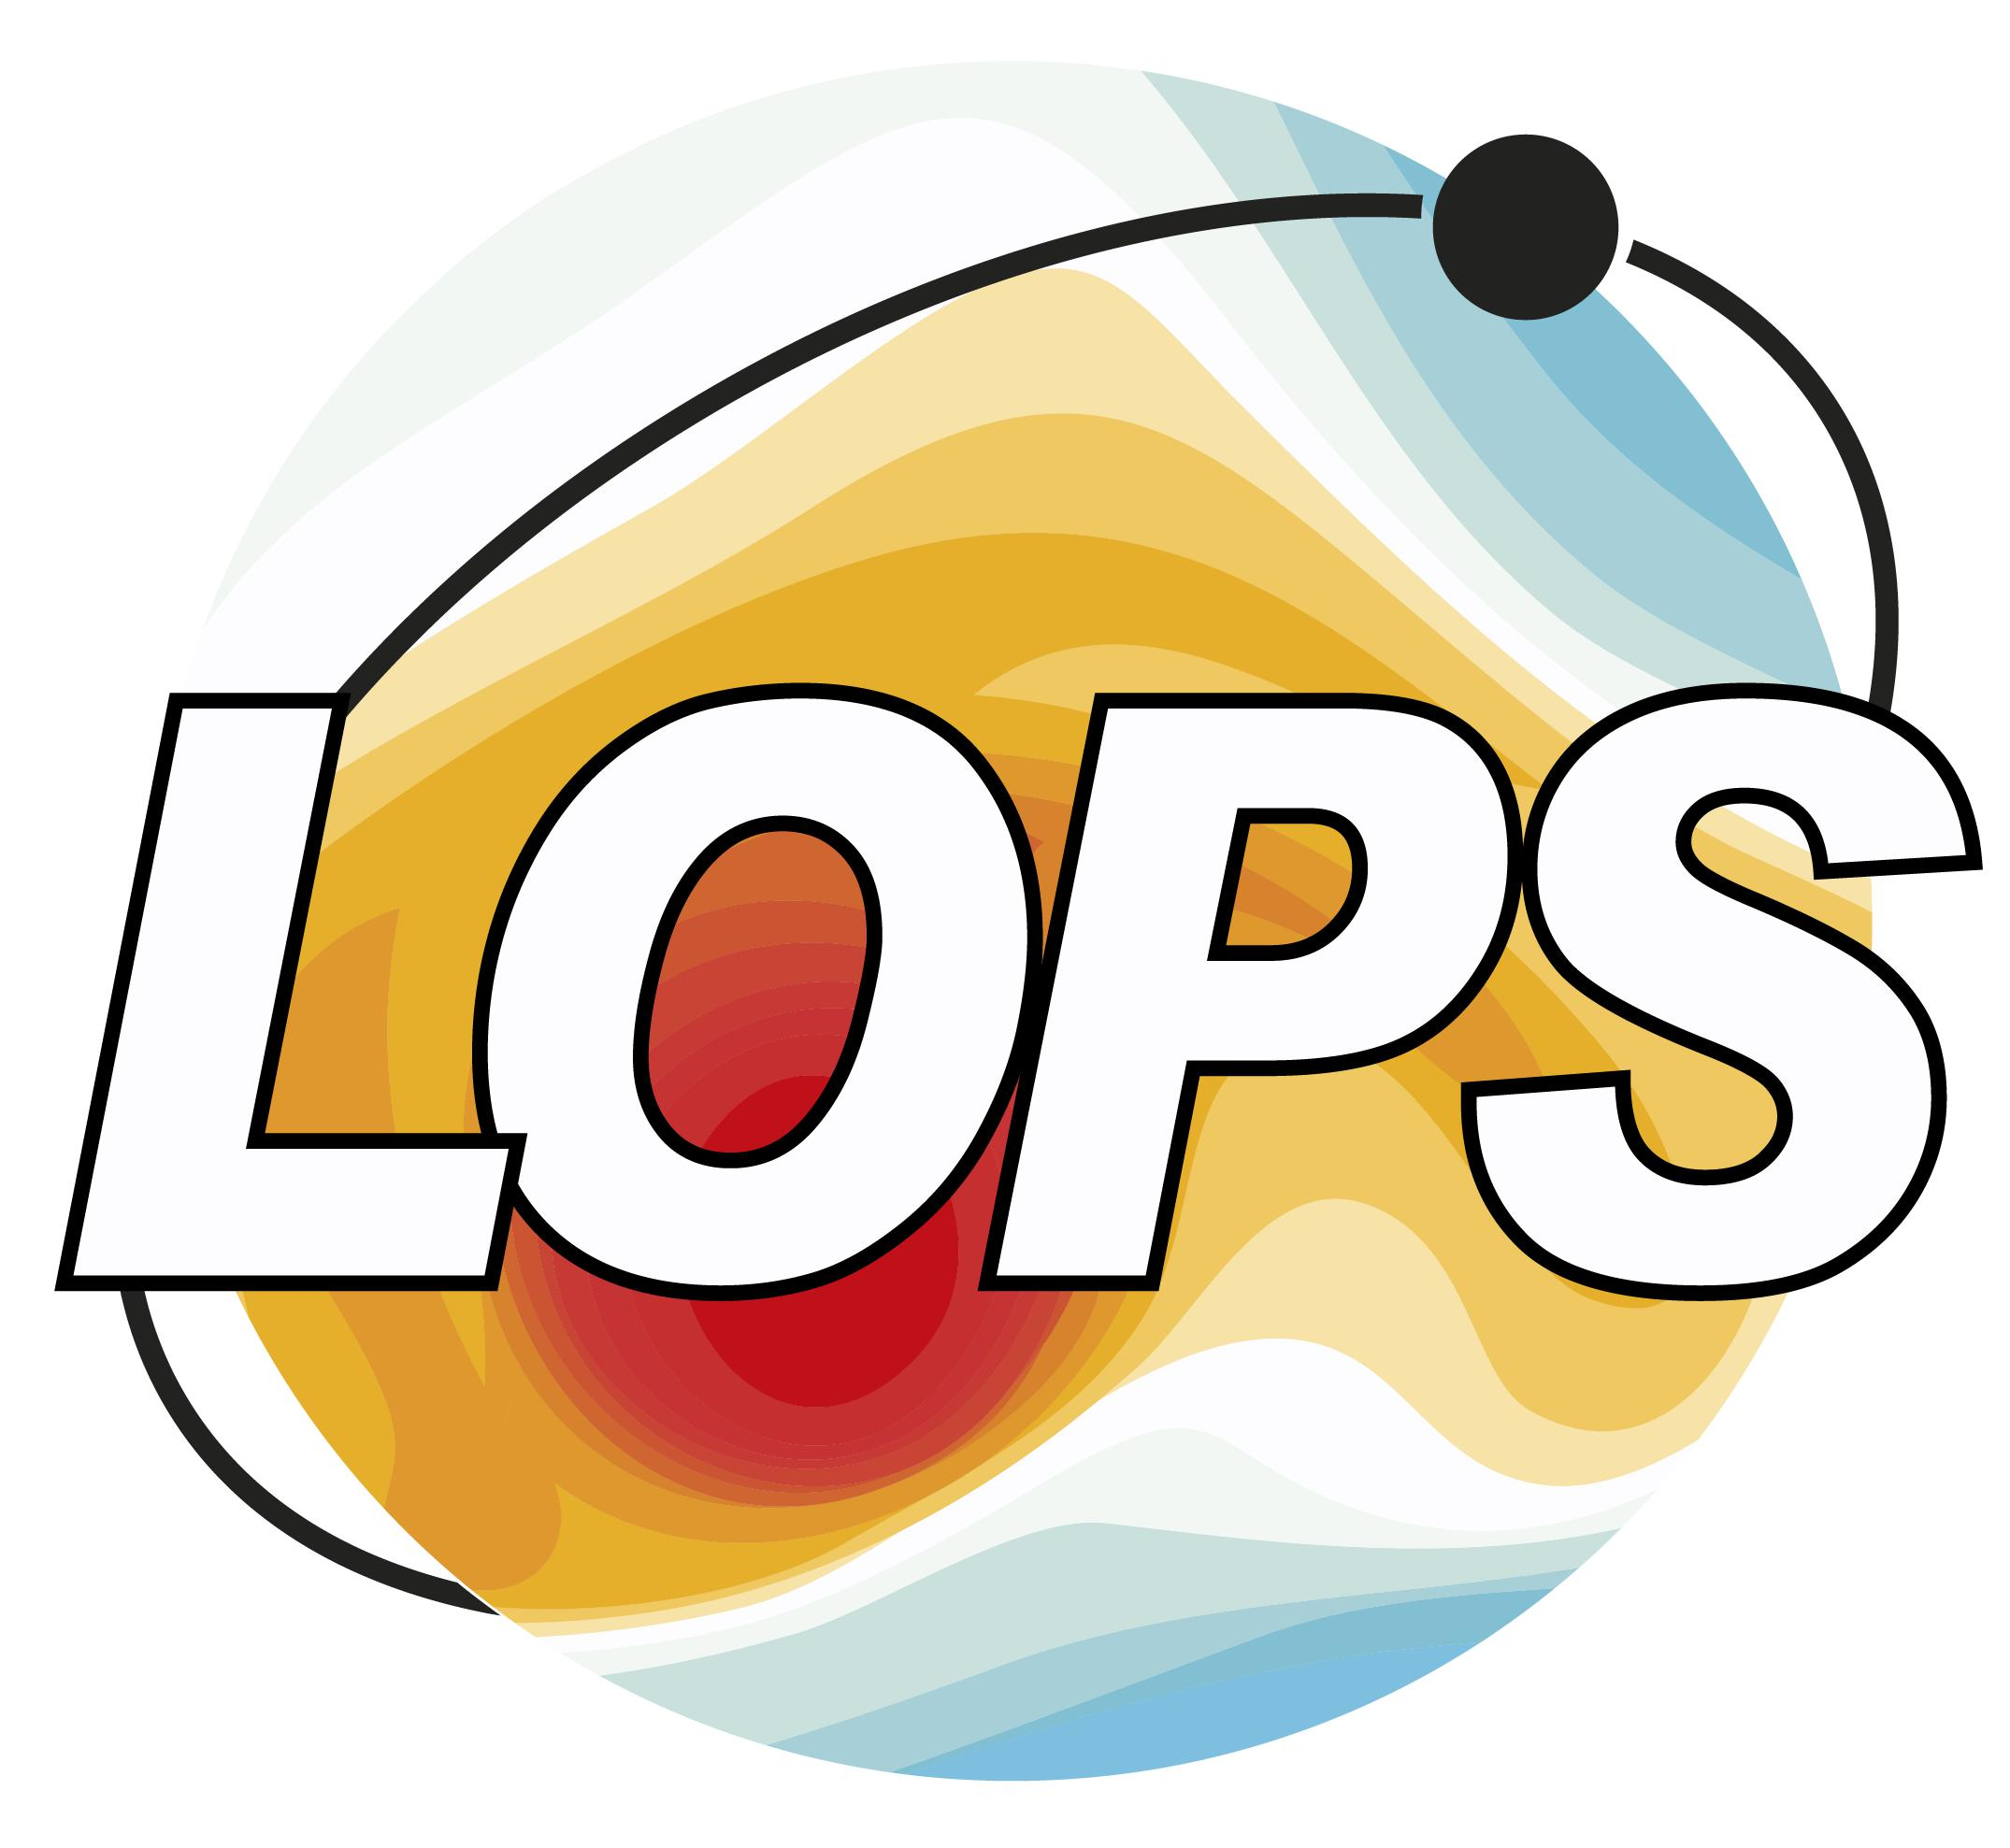 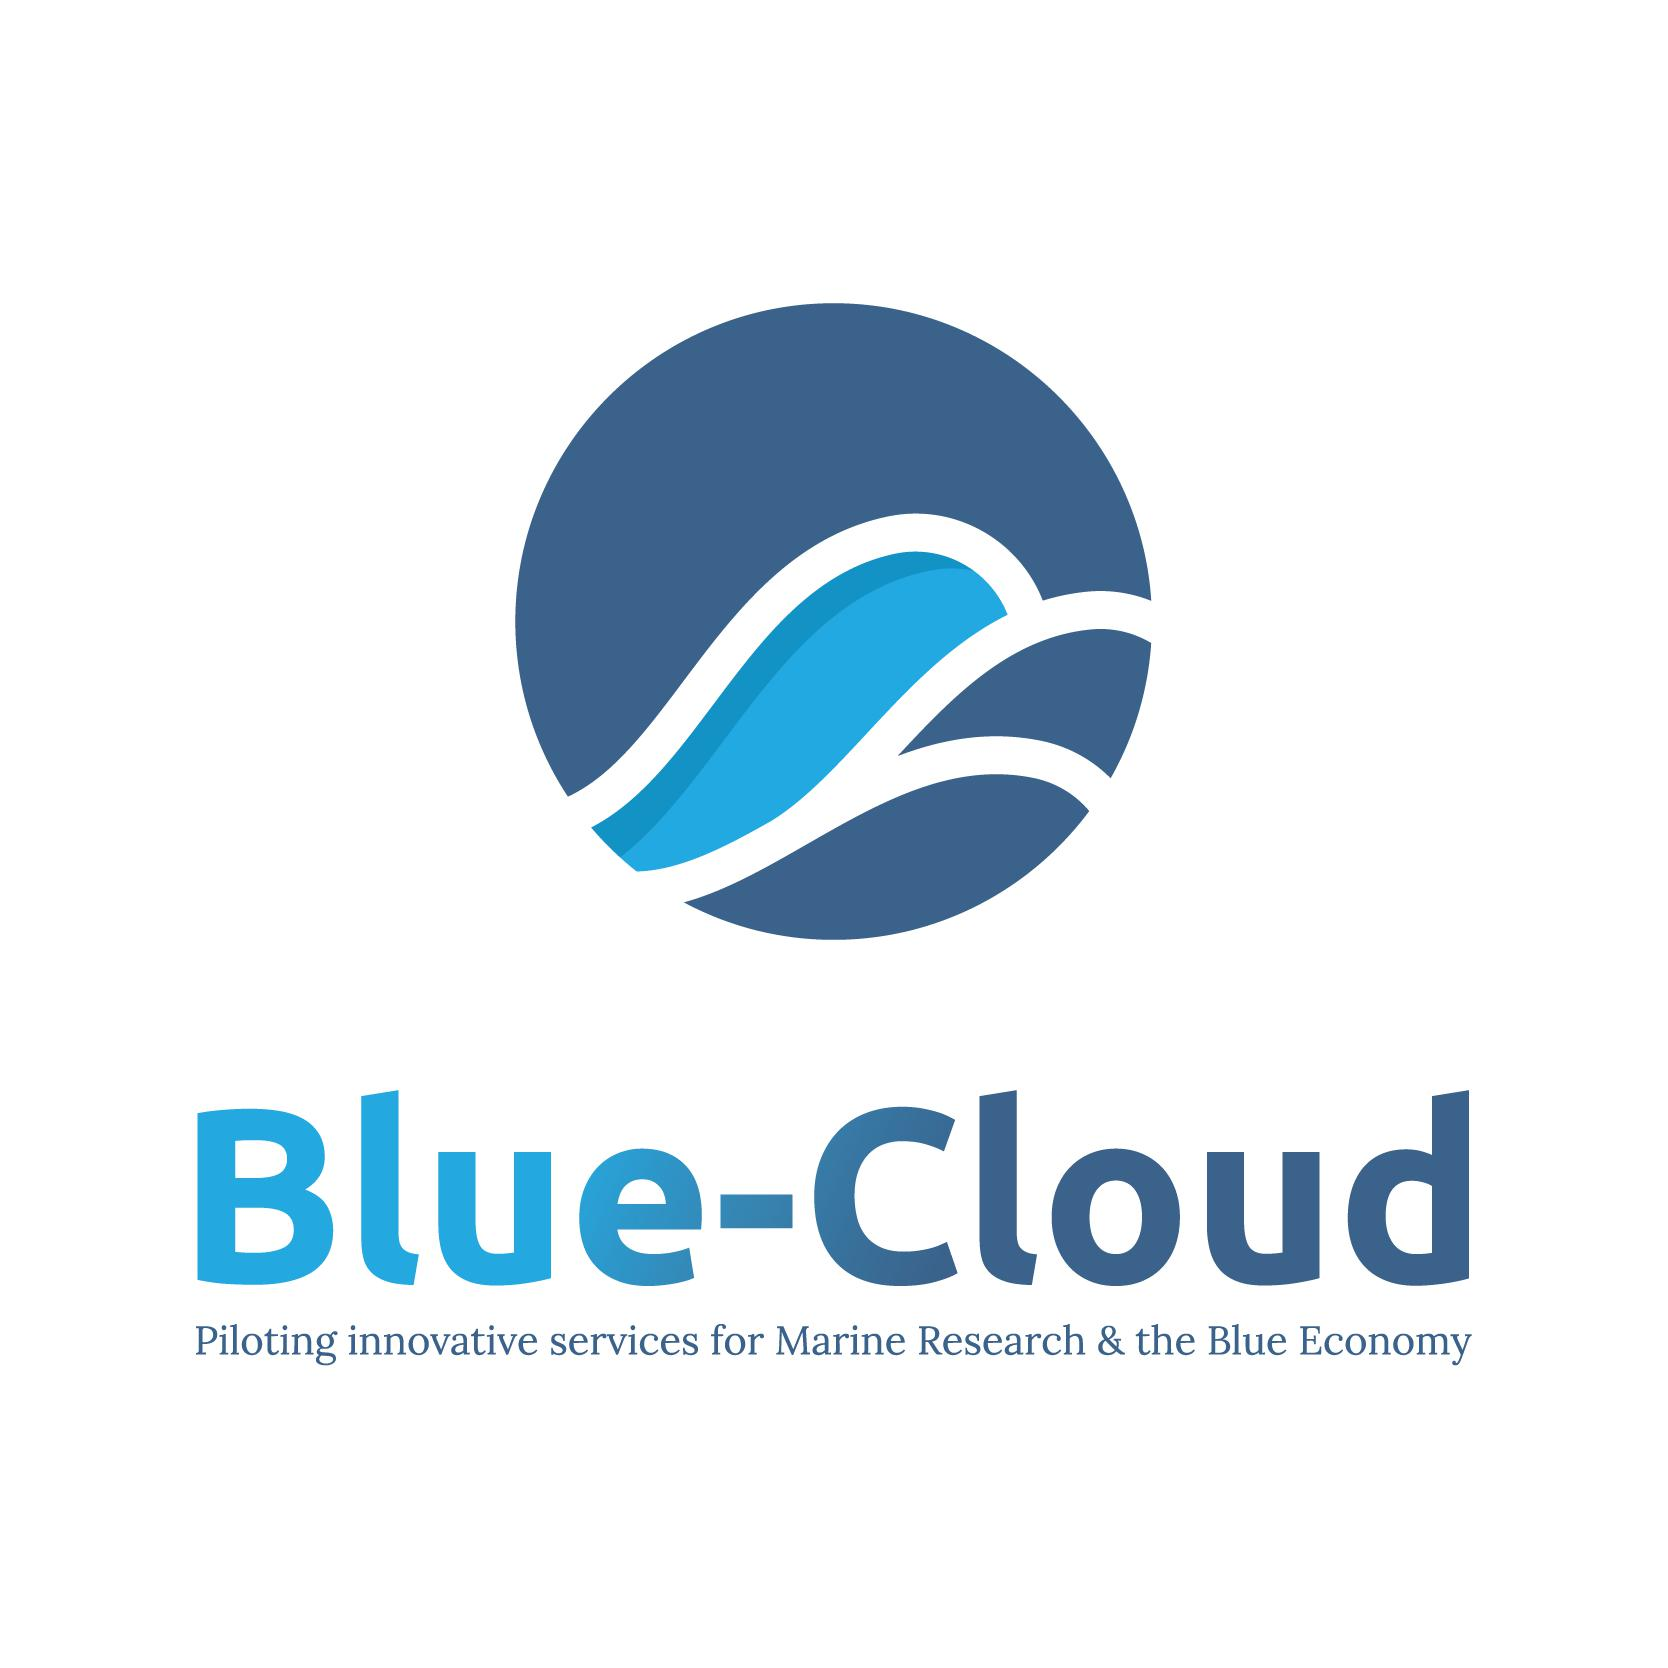</center>
</div>

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from preprocessing_OR import *

import Plotter_OR
from Plotter_OR import Plotter_OR 

import joblib

import subprocess

## Load model and dataset
***

In this section, you will download the __model__ and the __dataset__ and you should provide some information about them. 

You don't need to use the same dataset you used to train the model for making the prediction of labels. You can, for example, train the model with in-situ data and apply it to a numerical model dataset in order to evaluate the numerical model realism.

__Load model__

You can choose an already trained model, available for you in *models/* folder, or you can design your own model using the ``ModelDevelopment_OceanRegimes.ipynb`` notebook. 

In the cell below you should provide the model path.

In [2]:
# Model path
model_path = 'models/test_modelOR_mediterranean_chl_2019_k7_mid2.sav'

Load the chosen model.

In [3]:
model = joblib.load(model_path)
K = model.n_components
model

GaussianMixture(n_components=7)

__Load dataset__

Dataset is downloaded from CMEMS servers, so you will need to have a __CMEMS account__ (you can sign up [here](https://resources.marine.copernicus.eu/?option=com_csw&task=results?option=com_csw&view=account)).

You should provide your CMEMS __user name__ and __password__ below.

In [4]:
CMEMS_user = '###########'
CMEMS_password = '###########'

Data comes from daily Chlorophyll-a fields of *OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082* product, based on a space-time interpolation and a multi-sensors approach and with a spatial resolution of 4km (click [here](https://resources.marine.copernicus.eu/?option=com_csw&view=details&product_id=OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082) for getting all the information about the dataset). As an example, we propose to you a selection covering the Mediterranean sea during 2019.

If you feel confident you can modify downloading parameters (cell below) to test other dataset selections than the one we propose here (covering the Mediterranean). You can also test other variables. Please, be careful with memory limits: do not choose very big geographical extents or very long time series.

In [5]:
# geographical extent
geo_extent = [-5, 42, 30, 46] # [min lon, max lon, min lat, max lat]
# time extent
time_extent = ["2019-06-01", "2019-12-29"] # ["min date", "max date"]
# variable to be predict
var_name = 'CHL' # name in dataset
# file name
file_name = 'oceancolour_glo_chl_l4_rep_observations_009_082_mid2019_2.nc'

Dataset is downloaded from __CMEMS__ servers using a Motu client and saved as a __NetCDF__ file in the *datasets/* folder in your work space. Download will take a few minutes.

In [6]:
bashCommand = 'python -m motuclient -u ' + CMEMS_user + ' -p ' + CMEMS_password + ' -m "http://my.cmems-du.eu/motu-web/Motu" \
-s OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082-TDS -d dataset-oc-glo-bio-multi-l4-chl_interpolated_4km_daily-rep \
-x ' + str(geo_extent[0]) + ' -X ' + str(geo_extent[1]) + ' -y ' + str(geo_extent[2]) + ' -Y ' + str(geo_extent[3]) + \
' -t "' + time_extent[0] + '" -T "' + time_extent[1] + '" -z 0.0 -Z 2500.0 \
-v ' + var_name + ' -o datasets -f ' + file_name
print(bashCommand)
sp = subprocess.call(bashCommand, shell=True)

python -m motuclient -u ########### -p ########### -m "http://my.cmems-du.eu/motu-web/Motu" -s OCEANCOLOUR_GLO_CHL_L4_REP_OBSERVATIONS_009_082-TDS -d dataset-oc-glo-bio-multi-l4-chl_interpolated_4km_daily-rep -x -5 -X 42 -y 30 -Y 46 -t "2019-06-01" -T "2019-12-29" -z 0.0 -Z 2500.0 -v CHL -o datasets -f oceancolour_glo_chl_l4_rep_observations_009_082_mid2019_2.nc


Finally, the dataset is loaded from the NetCDF file as an *xarray* dataset:

In [7]:
file_path = 'datasets/' + file_name
ds = xr.open_dataset(file_path)

# some format
ds['time'] = ds.indexes['time'].to_datetimeindex()
ds.time.attrs['axis'] = 'T'

print(ds)

<xarray.Dataset>
Dimensions:  (lat: 385, lon: 1128, time: 212)
Coordinates:
  * time     (time) datetime64[ns] 2019-06-01 2019-06-02 ... 2019-12-29
  * lat      (lat) float32 46.02 45.98 45.94 45.9 ... 30.15 30.1 30.06 30.02
  * lon      (lon) float32 -4.979 -4.937 -4.896 -4.854 ... 41.9 41.94 41.98
Data variables:
    CHL      (time, lat, lon) float32 ...
Attributes: (12/65)
    comment:                      average
    distribution_statement:       See CMEMS Data License
    site_name:                    GLO
    parameter_code:               CHL
    creation_time:                16:39:54 UTC
    creation_date:                2020-11-05 UTC
    ...                           ...
    parameter:                    Chlorophyll-a concentration
    History:                      Translated to CF-1.0 Conventions by Netcdf-...
    geospatial_lat_min:           30.020832061767578
    geospatial_lat_max:           46.02083206176758
    geospatial_lon_min:           -4.979161262512207
    geospat

Quick plot of the training dataset. Please, choose a time slice if needed.

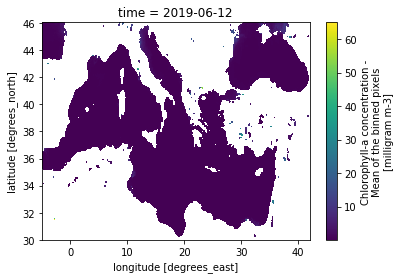

In [8]:
ds[var_name].isel(time=11).plot();

You can also plot the dataset __histogram__ and a __box plot__ to have an idea of Chlorophyll-a values distribution. Here we use a logarithmic scale because of the amount of outliers in the example dataset. If you don't need a logarithmic scale for your dataset, feel free to modify the cell below.

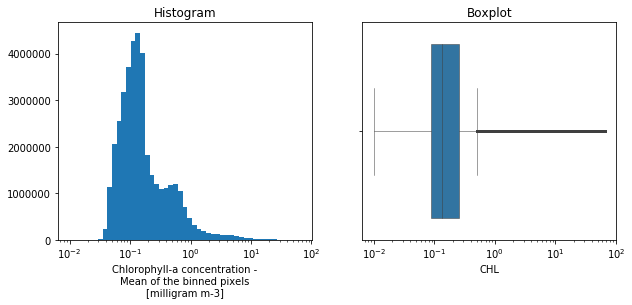

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
# histogram
bins = np.logspace(np.log10(ds[var_name].min().values),np.log10(ds[var_name].max().values), 50) # log bins
ds[var_name].plot.hist(bins=bins, ax=ax[0], xscale="log");
# boxplot
g2 = sns.boxplot(x=ds[var_name], fliersize=1, linewidth=0.5, ax=ax[1])
g2.set_xscale("log")
g2.set_title("Boxplot");

## Preprocessing
***

Before using the training dataset, you need to format it. The preprocessing phase consists of 5 different steps that are explained below.

__1. Weekly mean__

For each time series (each pixel) a weekly mean is applied. It allows us to __smooth the time series__, focusing on the seasonal variability. The dimensions on the dataset are also reduced, so processing time will be shortened. If your dataset contains more than one year, all years are taken together in the weakly mean, creating weekly climatological time series. This “*week*” dimension will be called “*feature*” in the preprocessed dataset.

In [10]:
X = OR_weekly_mean(ds, var_name=var_name)

__2. Reduce latitude and longitude dimensions to sampling dimension__

The dataset is stacked into a __2D dataset__ with dimensions "*feature*" (corresponding to weeks) and "*sampling*" (corresponding to latitude and longitude). Latitude and longitude information is not taken into account by the model: it only sees a set of "independent" time series and uses the similarities in temporal variability to make the clusters. 

In [11]:
X = OR_reduce_dims(X)

__3. Delate all NaN values__

NaNs values are removed using a __mask__. Here we use our own Mediterranean mask for removing the Black Sea, the Atlantic Ocean, and the lakes. If you are using a different dataset, you can use your own mask (look at the *docstring* of the function to know mask requirements) or you can automatically produce your mask from the dataset (default option ``mask_path='auto'``). The mask will be used below for unstacking the final dataset.

In [12]:
X, mask = OR_delate_NaNs(X, var_name =var_name, mask_path='datasets/Mediterranean_mask.nc')

Quick plot of the mask.

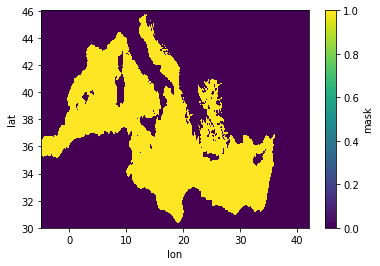

In [13]:
mask['mask'].plot()

__4. Scaler__

The sklearn __StandardScaler__ is applied: it standardizes the *feature* dimension by removing the mean and scaling to unit variance. For more information, see [sklearn doc](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

Depending on your dataset you may prefer to use other scalers. You can choose other options using the ``scaler_name`` input: [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html) and [MinMax Scaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html).  

In [14]:
X = OR_scaler(X, var_name=var_name)

__5. Principal Component Analysis (PCA)__

A PCA (Principal Component Analysis) is applied. The PCA __reduces the feature dimensions__ by projecting the data into a lower-dimensional space. With the ``n_components`` option, you can choose the amount of variance that needs to be explained by the reduced components (default value is 0.99).

In [15]:
X = OR_apply_PCA(X, var_name=var_name)

The preprocessed dataset contains a new "__*CHL_reduced*__" variable with dimensions "*feature_reduced*" and "*sampling*" that will be used to predict class labels.

In [16]:
print(X)

<xarray.Dataset>
Dimensions:      (feature: 31, feature_reduced: 23, sampling: 140699)
Coordinates:
  * feature      (feature) int64 22 23 24 25 26 27 28 ... 46 47 48 49 50 51 52
  * sampling     (sampling) MultiIndex
  - lat          (sampling) float64 45.73 45.73 45.73 ... 30.35 30.35 30.35
  - lon          (sampling) float64 13.56 13.6 13.65 13.19 ... 19.23 19.27 19.31
Dimensions without coordinates: feature_reduced
Data variables:
    CHL          (sampling, feature) float32 3.965 6.854 6.258 ... 0.2549 0.2506
    CHL_scaled   (sampling, feature) float32 10.4 12.94 13.24 ... -0.1358 -0.229
    CHL_reduced  (sampling, feature_reduced) float32 55.01 25.78 ... -0.04378


## Predict labels
***

Results of the classification (e.g. labels and some other statistics) are computed in the cells below. 
These new variables are simply added to the preprocessed dataset ``X``.

__Predict class labels__

The trained model instance (here called ``model``) contains all the necessary information to classify time series from the dataset we just loaded.
Each time series in this dataset will be attributed (__predicted__) to one of the model classes. A new variable *GMM_labels* is created to host this result in the preprocessed dataset ``X``.

In [17]:
X_labels = model.predict(X[var_name + "_reduced"])
X = X.assign(variables={"GMM_labels":(('sampling'),X_labels)})
print(X)

<xarray.Dataset>
Dimensions:      (feature: 31, feature_reduced: 23, sampling: 140699)
Coordinates:
  * feature      (feature) int64 22 23 24 25 26 27 28 ... 46 47 48 49 50 51 52
  * sampling     (sampling) MultiIndex
  - lat          (sampling) float64 45.73 45.73 45.73 ... 30.35 30.35 30.35
  - lon          (sampling) float64 13.56 13.6 13.65 13.19 ... 19.23 19.27 19.31
Dimensions without coordinates: feature_reduced
Data variables:
    CHL          (sampling, feature) float32 3.965 6.854 6.258 ... 0.2549 0.2506
    CHL_scaled   (sampling, feature) float32 10.4 12.94 13.24 ... -0.1358 -0.229
    CHL_reduced  (sampling, feature_reduced) float32 55.01 25.78 ... -0.04378
    GMM_labels   (sampling) int64 1 1 1 1 1 1 1 1 1 1 1 ... 4 4 6 4 4 4 4 6 4 4


__Probability of a profile to be in a class__

As the GMM ([Gaussian Mixture Model](https://scikit-learn.org/stable/modules/mixture.html)) is a fuzzy classifier, it is possible to calculate the probability of a time series to belong to a class, also called __posterior__. This is the first step to determine the robustness of the classification, which will be calculated below. A new variable *GMM_post* is created.

In [18]:
X_proba = model.predict_proba(X[var_name + "_reduced"])
X = X.assign(variables={"GMM_post":(('sampling','k'),X_proba)})
print(X)

<xarray.Dataset>
Dimensions:      (feature: 31, feature_reduced: 23, k: 7, sampling: 140699)
Coordinates:
  * feature      (feature) int64 22 23 24 25 26 27 28 ... 46 47 48 49 50 51 52
  * sampling     (sampling) MultiIndex
  - lat          (sampling) float64 45.73 45.73 45.73 ... 30.35 30.35 30.35
  - lon          (sampling) float64 13.56 13.6 13.65 13.19 ... 19.23 19.27 19.31
Dimensions without coordinates: feature_reduced, k
Data variables:
    CHL          (sampling, feature) float32 3.965 6.854 6.258 ... 0.2549 0.2506
    CHL_scaled   (sampling, feature) float32 10.4 12.94 13.24 ... -0.1358 -0.229
    CHL_reduced  (sampling, feature_reduced) float32 55.01 25.78 ... -0.04378
    GMM_labels   (sampling) int64 1 1 1 1 1 1 1 1 1 1 1 ... 4 4 6 4 4 4 4 6 4 4
    GMM_post     (sampling, k) float64 0.0 1.0 ... 4.892e-31 0.0004664


__Classes quantiles__

Class time series structure can be represented using the quantiles of all time series corresponding to a class. We advise you to calculate at least the __median profile__ and the 5% and 95% quantiles (`q=[0.05, 0.5, 0.95]`) to have a minimal representation of the classes but feel free to add other quantiles if you want. You have the option to plot the scaled variable if you prefer. A new variable `var_q + '_Q'` is added to the dataset.

In [19]:
# quantiles we want to calculate
q = [0.05, 0.5, 0.95]
# we can use the normal variable or the scaled variable
var_q = 'CHL' # or var_q = 'CHL_scaled'

In [20]:
k_values = np.unique(X['GMM_labels'].values)

nan_matrix = np.empty((K, np.size(q),np.size(X.feature)))
nan_matrix[:] = np.NaN
m_quantiles = xr.DataArray(nan_matrix, dims=['k','quantile', 'feature'])

for yi in range(K):
    if yi in k_values:
        m_quantiles[yi] = X[var_q].where(X['GMM_labels']==yi, drop=True).quantile(q, dim='sampling')

X = X.assign(variables={var_q + "_Q":(('k','quantile','feature'), m_quantiles)})
X = X.assign_coords(coords={'quantile': q})
print(X)

<xarray.Dataset>
Dimensions:      (feature: 31, feature_reduced: 23, k: 7, quantile: 3, sampling: 140699)
Coordinates:
  * feature      (feature) int64 22 23 24 25 26 27 28 ... 46 47 48 49 50 51 52
  * sampling     (sampling) MultiIndex
  - lat          (sampling) float64 45.73 45.73 45.73 ... 30.35 30.35 30.35
  - lon          (sampling) float64 13.56 13.6 13.65 13.19 ... 19.23 19.27 19.31
  * quantile     (quantile) float64 0.05 0.5 0.95
Dimensions without coordinates: feature_reduced, k
Data variables:
    CHL          (sampling, feature) float32 3.965 6.854 6.258 ... 0.2549 0.2506
    CHL_scaled   (sampling, feature) float32 10.4 12.94 13.24 ... -0.1358 -0.229
    CHL_reduced  (sampling, feature_reduced) float32 55.01 25.78 ... -0.04378
    GMM_labels   (sampling) int64 1 1 1 1 1 1 1 1 1 1 1 ... 4 4 6 4 4 4 4 6 4 4
    GMM_post     (sampling, k) float64 0.0 1.0 ... 4.892e-31 0.0004664
    CHL_Q        (k, quantile, feature) float64 nan nan nan ... 0.3569 0.4155


__Robustness__

The classification robustness is a scaled version of the __probability__ of a time series to belong to a class (i.e. the posteriors) so that the value range is more appropriate to assess the **robustness** of a classification. 
A 0 value indicates the model is totally unsure of the classification result (all classes are equiprobable), while values close to 1 indicate the model is highly confident of the result. 
Note that this does not prevail the scientific mean of the classification, but rather indicates the ability of the model to attribute a time series to a specific class with confidence.

Two new variables are added to the dataset: *GMM_robustness* and *GMM_robustness_cat*. The 2nd variable is categorical and is based on the IPCC likelihood scale:

| Robustness range | Category          |
|------------------|-------------------|
| 0-33%            | Unlikely          |
| 33%-66%          | As likely as not  |
| 66%-90%          | Likely            |
| 90%-99%          | Very likely       |
| 99%-100%         | Virtually certain |

In [21]:
maxpost = X["GMM_post"].max(dim="k")
nK = len(X["GMM_labels"])
robust = (maxpost - 1. / nK) * nK / (nK - 1.)

Plist = [0, 0.33, 0.66, 0.9, .99, 1]
rowl0 = ('Unlikely', 'As likely as not', 'Likely', 'Very Likely', 'Virtually certain')
robust_id = np.digitize(robust, Plist) - 1

X = X.assign(variables={"GMM_robustness":(('sampling'), robust), "GMM_robustness_cat":(('sampling'), robust_id)})
X["GMM_robustness_cat"].attrs['legend'] = rowl0

print(X)

<xarray.Dataset>
Dimensions:             (feature: 31, feature_reduced: 23, k: 7, quantile: 3, sampling: 140699)
Coordinates:
  * feature             (feature) int64 22 23 24 25 26 27 ... 47 48 49 50 51 52
  * sampling            (sampling) MultiIndex
  - lat                 (sampling) float64 45.73 45.73 45.73 ... 30.35 30.35
  - lon                 (sampling) float64 13.56 13.6 13.65 ... 19.27 19.31
  * quantile            (quantile) float64 0.05 0.5 0.95
Dimensions without coordinates: feature_reduced, k
Data variables:
    CHL                 (sampling, feature) float32 3.965 6.854 ... 0.2506
    CHL_scaled          (sampling, feature) float32 10.4 12.94 ... -0.229
    CHL_reduced         (sampling, feature_reduced) float32 55.01 ... -0.04378
    GMM_labels          (sampling) int64 1 1 1 1 1 1 1 1 1 ... 4 6 4 4 4 4 6 4 4
    GMM_post            (sampling, k) float64 0.0 1.0 ... 4.892e-31 0.0004664
    CHL_Q               (k, quantile, feature) float64 nan nan ... 0.3569 0.4155
   

Finally, the dataset including results is __unstacked__.

In [22]:
ds_labels = OR_unstack_dataset(ds, X, mask)
print(ds_labels)

<xarray.Dataset>
Dimensions:             (feature: 31, feature_reduced: 23, k: 7, lat: 385, lon: 1128, quantile: 3, time: 212)
Coordinates:
  * lat                 (lat) float64 30.02 30.06 30.1 ... 45.94 45.98 46.02
  * lon                 (lon) float64 -4.979 -4.937 -4.896 ... 41.9 41.94 41.98
  * feature             (feature) int64 22 23 24 25 26 27 ... 47 48 49 50 51 52
  * quantile            (quantile) float64 0.05 0.5 0.95
  * time                (time) datetime64[ns] 2019-06-01 ... 2019-12-29
Dimensions without coordinates: feature_reduced, k
Data variables:
    CHL                 (feature, lat, lon) float32 nan nan nan ... nan nan nan
    CHL_scaled          (feature, lat, lon) float32 nan nan nan ... nan nan nan
    CHL_reduced         (feature_reduced, lat, lon) float32 nan nan ... nan nan
    GMM_labels          (lat, lon) float64 nan nan nan nan ... nan nan nan nan
    GMM_post            (k, lat, lon) float64 nan nan nan nan ... nan nan nan
    CHL_Q               (k, qu

## Plot results
***

Plots are created using the *Plotter_OR* class, which is instantiated below. Plots include the time series structure and the spatial distribution of classes. These plots will allow you to determine if classes show a spatial coherence: the __Ocean Regimes Indicator__.

The ``save_BlueCloud`` function saves the figure and adds dataset information and logos below.

Please, feel free to change plot options if you need it.

In [23]:
P = Plotter_OR(ds_labels, model)

#### __1. Time series structure__

The graphic representation of quantile time series reveals the seasonal structure of each class.
The median time series will give you the best idea of the __typical time series__ of a class and the other quantiles, the possible __spread__ of time series within a class.
You can choose the start month in the plot: here we use ``start_month=6`` to highlight the seasonal blooms .

Figure saved in figures/tseries_struc_EX_chl.png


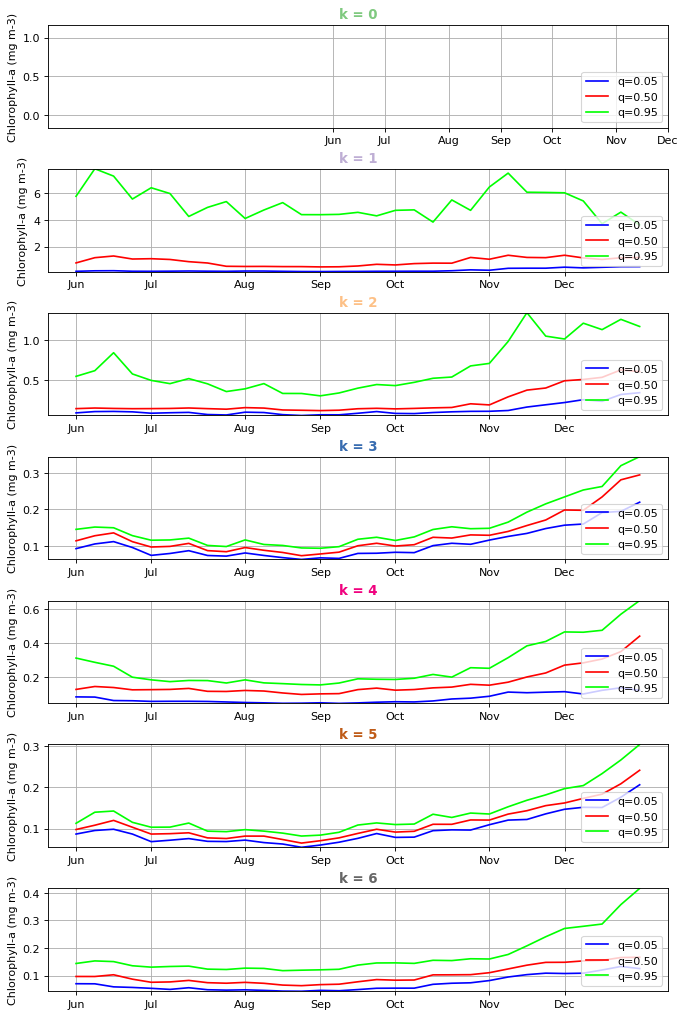

In [24]:
P.tseries_structure(q_variable = var_q + '_Q', ylabel='Chlorophyll-a (mg m-3)')
P.save_BlueCloud('figures/tseries_struc_EX_chl.png')

Quantiles can also be plotted __together__ to highlight differences between classes. Using the `plot_q` option you can choose the quantiles you want to plot together.

[ 1  6  7  8  9 10 11 12]
['Jan', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
Figure saved in figures/tseries_struc_comp_EX_chl.png


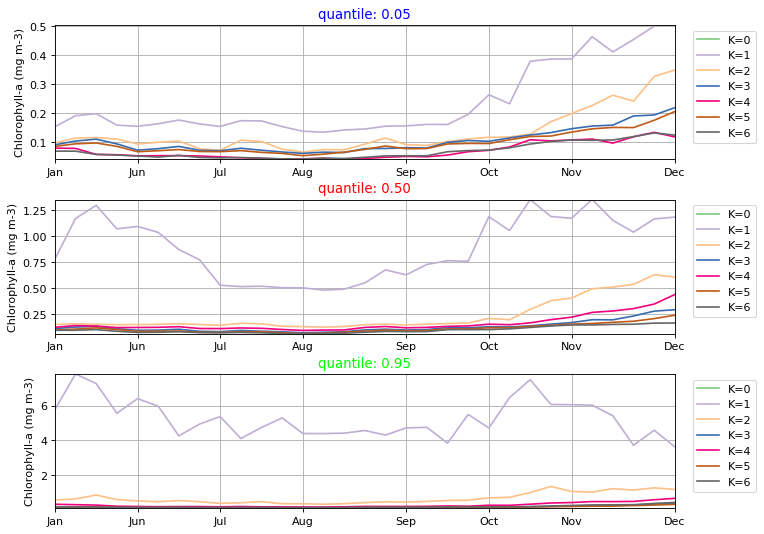

In [25]:
P.tseries_structure_comp(q_variable = var_q + '_Q', plot_q= 'all', ylabel='Chlorophyll-a (mg m-3)')
P.save_BlueCloud('figures/tseries_struc_comp_EX_chl.png')

#### __2. Spatial distribution of classes__

You can also plot the GMM labels in a map to analyse the spatial coherence of classes. The spatial information (coordinates) of time series is not used to fit the model, so spatial coherence appears naturally, revealing seasonal structure similarities between different areas of the ocean. If you detect any spatial coherence, well done, you have found an __Ocean Regimes Indicator__!.

Figure saved in figures/spatial_distr_EX_chl.png


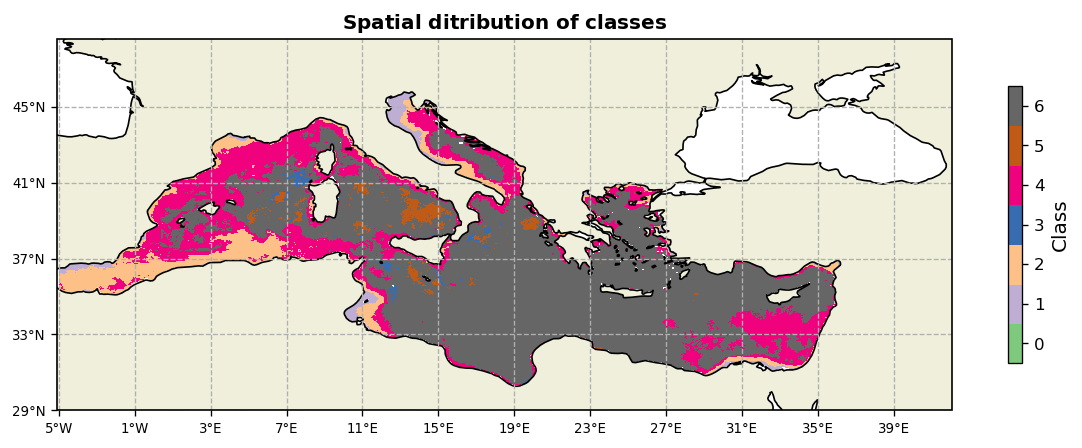

In [26]:
P.spatial_distribution()
P.save_BlueCloud('figures/spatial_distr_EX_chl.png')

#### __3. Robustness__

Robustness is a scaled __probability__ of a time series to belong to a class. 
When looking at the spatial distribution of the robustness metric, and if classes have a spatial structure, you may encounter regions with high probabilities: these regions are the "core" of the class. 

Figure saved in figures/robustness_EX_chl.png


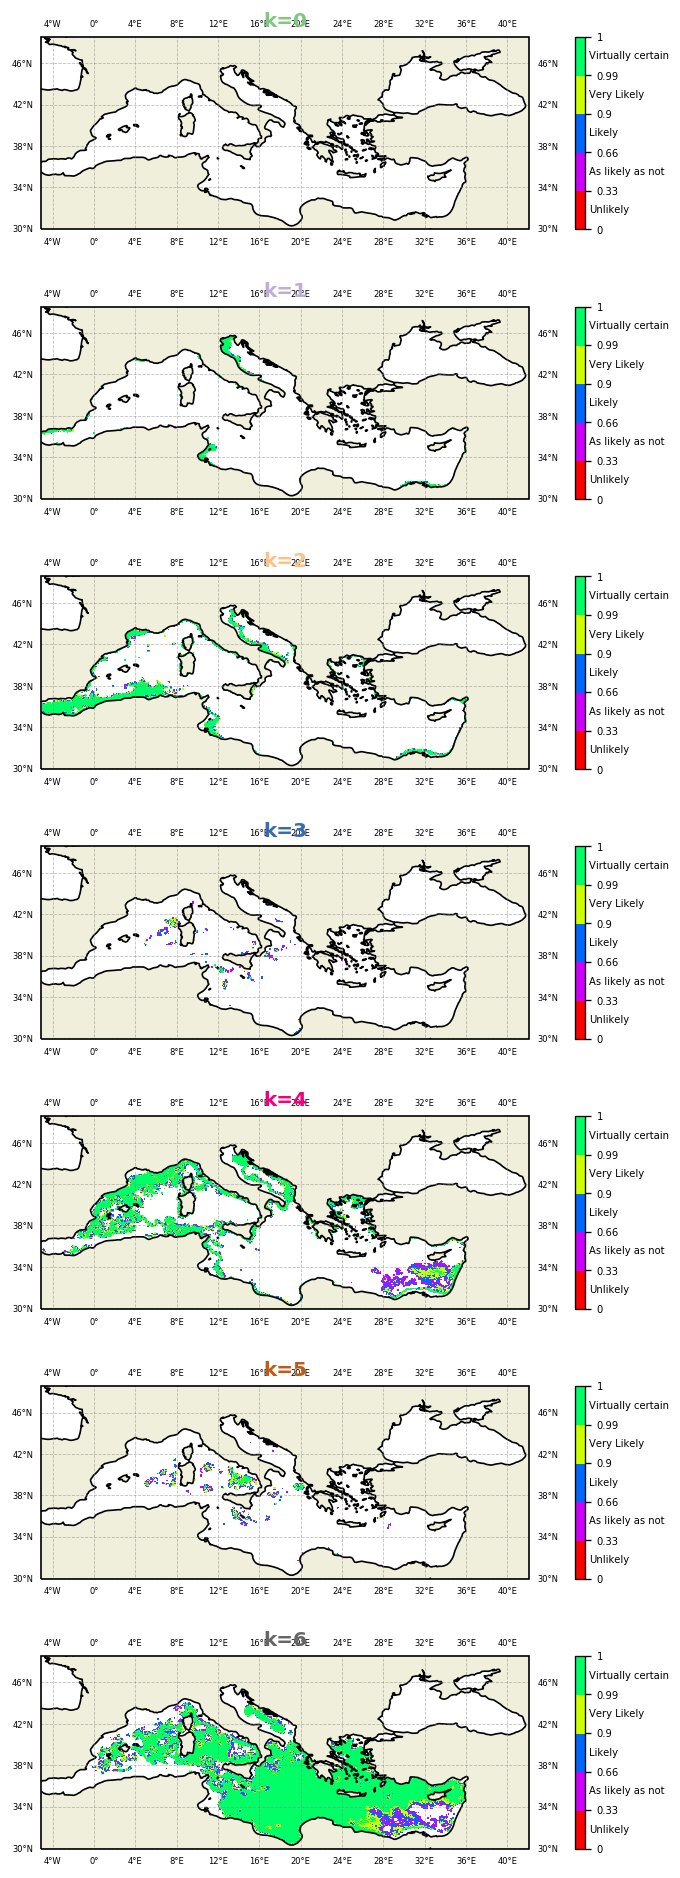

In [27]:
P.plot_robustness()
P.save_BlueCloud('figures/robustness_EX_chl.png')

#### __4. Classes pie chart__

Here you can plot a pie chart showing the percentage of profiles belonging to each class and the number of classified profiles.

Figure saved in figures/pie_chart_EX_chl.png


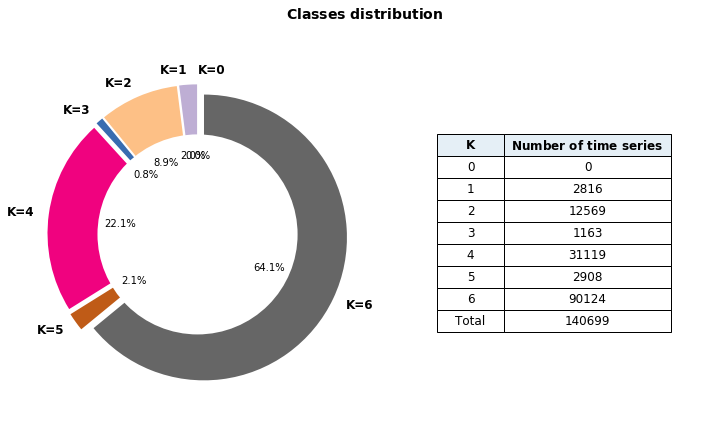

In [28]:
P.pie_classes()
P.save_BlueCloud('figures/pie_chart_EX_chl.png')

## Save data
***

If you are happy with the results and you want to work on the data on your own, you can save the dataset including the new GMM variables (GMM labels, robustness, …) in the cell below.

In [29]:
ds_labels.to_netcdf('datasets/OR_mediterranean_2019_CHL_predicted_dataset.nc')